# Student Matcher

In [77]:
%store -r columns_encoded
%store -r columns_encoded
%store -r columns
%store -r data
%store -r data_encoded
%store -r pseudonym_df

columns_encoded = columns_encoded
columns = columns
data = data
data_encoded = data_encoded

pseudonym_df = pseudonym_df

In [233]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb

import networkx as nx

import math

# 1 Ähnlichkeitsberechnung

In [79]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 82 columns):
 #   Column                                                                                                                      Non-Null Count  Dtype 
---  ------                                                                                                                      --------------  ----- 
 0   Alter                                                                                                                       62 non-null     int32 
 1   Als wie sportlich würdest du dich einschätzen?                                                                              62 non-null     int32 
 2   Welche Rolle spielt für dich gesunde Ernährung?                                                                             62 non-null     int32 
 3   Wie gerne gehst du Essen oder Trinken?                                                                                      62 non-n

Ergänzen der Pseudonyme zu den Daten...

In [80]:
data_encoded["Pseudonym"] = pseudonym_df

## TODO: Funktion implementieren

In [81]:
# Input: Two data series, each containing a row of a datapoint from data_encoded
def survey_similarity(person1, person2):

    # Drop non-numeric features and age, which is not used for comparison
    person1 = person1.drop(["Alter", "Pseudonym"])
    person2 = person2.drop(["Alter", "Pseudonym"])

    # Create DataFrame to store the difference between the two datapoints for each feature
    differences = pd.DataFrame(columns=["Feature", "Differenz"])

    # Iterate over all columns (features). This iteration assumes, that the second series contains the same columns (amount and names)
    for column in person1.keys():

        # compute the absolute distance for each feature and save the result in the DataFrame
        difference_p1_p2 = abs(person1[column] - person2[column])
        new_row = pd.DataFrame({'Feature': column, 'Differenz': difference_p1_p2}, index=[0])
        differences = pd.concat([new_row, differences.loc[:]]).reset_index(drop=True)
    
    # Compute the overall average distance from the individual computations of each feature-distance
    difference_score = differences["Differenz"].mean()
    return difference_score, differences

Beispielhafte Berechnung der Abstände mithilfe der Funktion, um Ausgabe verständlicher zu machen...

In [82]:
score, similarity_p1_p2 = survey_similarity(data_encoded.iloc[0], data_encoded.iloc[1])
similarity_p1_p2

,Feature,Differenz
0,Geschlecht (weiblich?),0
1,Genre Lieblingsmusiker Rock? (encoded),0
2,Genre Lieblingsmusiker Rap Hip Hop? (encoded),0
3,Genre Lieblingsmusiker Pop? (encoded),0
4,Genre Lieblingsmusiker Kein Lieblingsgenre? (e...,0
...,...,...
75,Wie gerne gehst du feiern?,1
76,Wie gerne kochst du selbst?,1
77,Wie gerne gehst du Essen oder Trinken?,1
78,Welche Rolle spielt für dich gesunde Ernährung?,0


Versuch, mit der internen Funktion .diff() die Distanzen performanter zu berechen. Hat bisher nicht allzu gut funktioniert...

In [83]:
# def survey_similarity_df(dataframe):
#     dataframe = dataframe.drop(["Alter", "Pseudonym"], axis=1)
#     dataframe = dataframe.diff()
#     return dataframe.T

# df = data_encoded.iloc[0:2]
# test = survey_similarity_df(df)
# test

Die Funktion berechnet für jede Kombination von Datenpunkten (die anhand ihrer Pseudonyme identifiziert werden) einen "Ähnlichkeitswert", indem für jedes Paar die Ähnlichkeitsberechnung durchgeführt wird. Um die Berechnung performanter zu machen, wird hierbei überprüft, ob bereits für das zugehörige Paar in umgekehrter Reihenfolge ein Wert berechnet wurde. Falls dem so ist, wird der Wert übernommen, da die Ähnlichkeitsberechnung symmetrisch ist und die Ähnlichkeit von Person1 zu Person2 genauso groß ist wie von Person2 zu Person1.

Die berechneten Ähnlichkeitswerte werden in einem (neuen) DataFrame gespeichert.

In [84]:
# Input:
#   - data: Dataframe containing the datapoints which should be compared
#   - reduced: Optional bool to determine, if comparisons of datapoints with themselves and different orders should be ignored (for a better evaluation & performance)
def compute_similarities(data, reduced=True):
    similarities = pd.DataFrame(columns=["person1", "person2", "similarity"])
    for i in range(0, len(data)-1):
        for j in range(0, len(data)-1):
            pseudo_p1 = data.iloc[i]["Pseudonym"]
            pseudo_p2 = data.iloc[j]["Pseudonym"]

            # If a Datapoint is compared to itself, the computation is aborted
            if(reduced & (pseudo_p1 == pseudo_p2)):
                continue
            
            # Mask checks whether there is already a computed value for the given pair, but in a swapped order
            mask_p2_p1 = (similarities["person1"] == pseudo_p2) & (similarities["person2"] == pseudo_p1)
            if len(similarities[mask_p2_p1]) > 0:
                # As the order of the given pair does not has an impact on the computation, the value can be replaced directly by the corresponding pair in the swapped order (or ignored completely)
                if reduced:
                    continue

                similarity_p1_p2 = similarities[mask_p2_p1].iloc[0]["similarity"]
            else:
                similarity_p1_p2, _ = survey_similarity(data.iloc[i], data.iloc[j])

            similarities.loc[len(similarities)] = [pseudo_p1, pseudo_p2, similarity_p1_p2]

    return similarities

Aufrufen der Funktion auf allen Datenpunkten, um alle Distanzwerte zu berechnen...

In [85]:
df_similarities = compute_similarities(data_encoded, reduced=False)
df_similarities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3721 entries, 0 to 3720
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   person1     3721 non-null   object 
 1   person2     3721 non-null   object 
 2   similarity  3721 non-null   float64
dtypes: float64(1), object(2)
memory usage: 116.3+ KB


In [86]:
df_similarities = compute_similarities(data_encoded, reduced=True)
df_similarities.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1830 entries, 0 to 1829
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   person1     1830 non-null   object 
 1   person2     1830 non-null   object 
 2   similarity  1830 non-null   float64
dtypes: float64(1), object(2)
memory usage: 57.2+ KB


Deprecated Code zum nachträglichen Entfernen von Vergleichen der Datenpunkte mit sich selbst. Ist jetzt in der Berechnungsmethode selbst enthalten (für reduced=True), kann also ggf. entfernt werden.

In [87]:
# df_removed_rows = df_similarities.iloc[0:0]
# df_similarities_wo_duplicates = df_similarities.copy()

# for row in df_similarities_wo_duplicates.iterrows():
#     if row[1][0] == row[1][1]:
#         df_removed_rows = pd.concat([row[1].T, df_removed_rows], ignore_index=True)
#         df_similarities_wo_duplicates = df_similarities_wo_duplicates.drop(row[0])

# df_similarities_wo_duplicates, df_removed_rows

Ausgabe der geordneten Scores. Aktuell wird die Ähnlichkeit durch den Abstand angegeben, was nicht der Intuition entspricht (kleiner ist "ähnlicher") Deshalb wird die Skalierung vor der Ausgabe "umgedreht".

In [88]:
df_similarities["similarity"] = 1-df_similarities["similarity"]

df_similarities = df_similarities.sort_values("similarity", ascending=False)
df_similarities

,person1,person2,similarity
868,123,asdf,0.7875
418,air-oughtest-wood-abate,ac1306,0.6375
417,air-oughtest-wood-abate,agalper,0.6125
106,hbstr,DRP,0.6125
662,bangnon123,7bpf8,0.6000
...,...,...,...
1204,nomercy,kevkev,0.0500
1594,aw17,JustTill,0.0500
298,242,sekkuro,0.0250
331,242,Ark,0.0250


In [267]:
# get the top 2% of the most similar students
top_2_percent_of_similarities = df_similarities.head(int(len(df_similarities)*(2/100)))
top_2_percent_of_similarities

,person1,person2,similarity
868,123,asdf,0.7875
418,air-oughtest-wood-abate,ac1306,0.6375
417,air-oughtest-wood-abate,agalper,0.6125
106,hbstr,DRP,0.6125
662,bangnon123,7bpf8,0.6000
606,Ismail,eprotizu,0.5750
19,lalala-lololo,FB42,0.5750
67,hbstr,Quantum342 (ChatGPT),0.5625
1732,Lm1711,Mk27,0.5625
79,hbstr,7bpf8,0.5625


# TODO: Die ersten paar Einträge vergleichen (sind die sich wirklich ähnlich?)

--> Selbes Cluster bei der Clusteranalyse? \
--> Einzelne Fragen: Wie viele Übereinstimmungen? \
--> usw.

# 2. Netzwerk-Analyse

In [268]:
edges = top_2_percent_of_similarities.rename(columns={'person1': 'source', 'person2': 'target', 'similarity': 'weight'})

G = nx.from_pandas_edgelist(edges, edge_attr=True)

In [269]:
people_not_yet_in_network = list(set(data_encoded.Pseudonym) - set(G.nodes()))

G.add_nodes_from(people_not_yet_in_network)

node_color_map = []
for node in G.nodes():
    if node in people_not_yet_in_network:
        node_color_map.append('lightsteelblue')
    else: 
        node_color_map.append('lightblue')

C:\Users\Janne\AppData\Local\Temp\ipykernel_14104\341351454.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Similarity of connection")


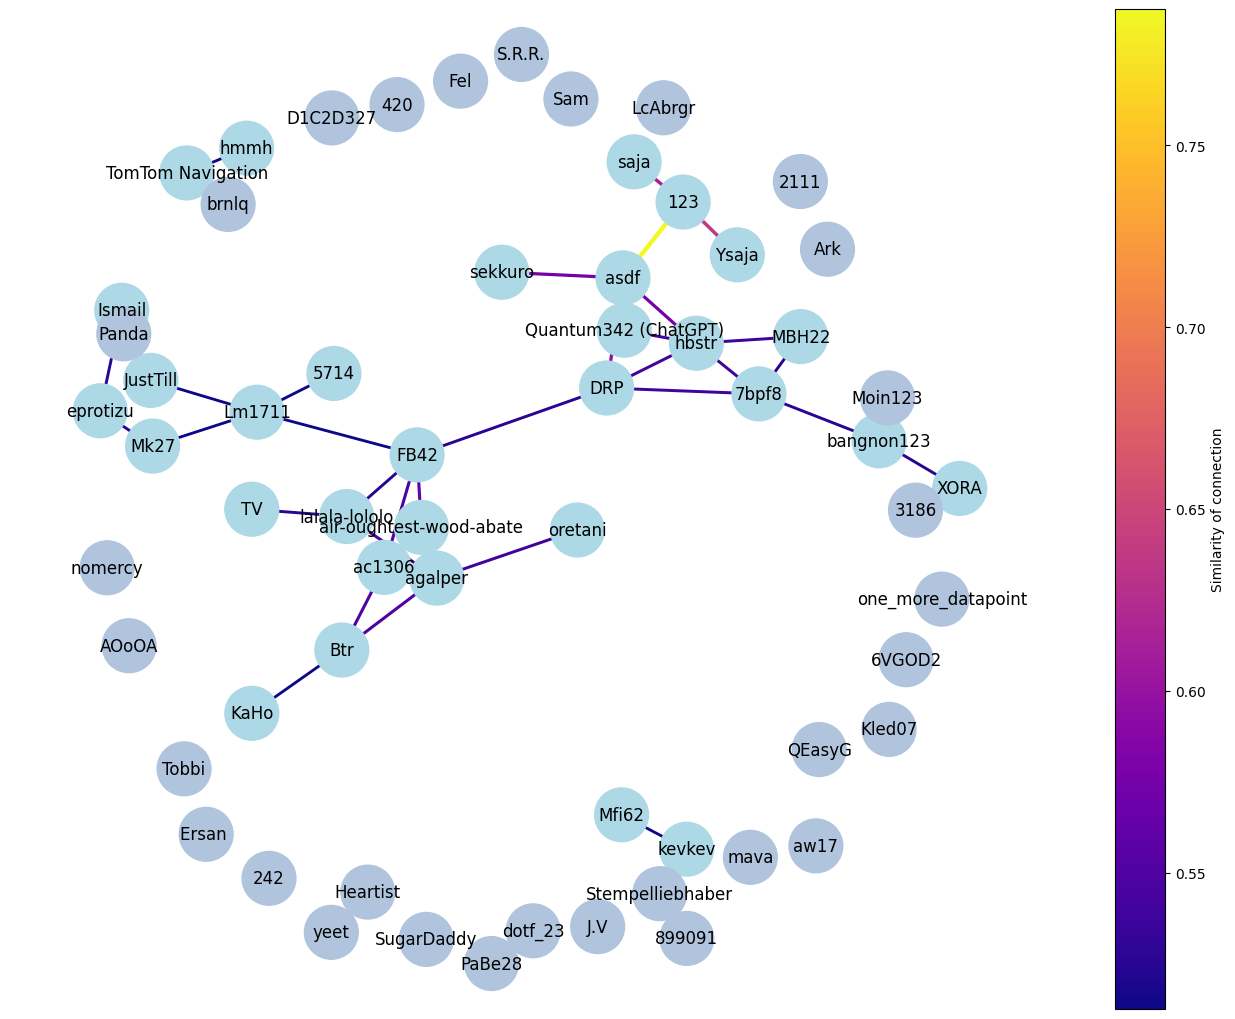

In [273]:
plt.figure(3, figsize=(13,10)) 
pos = nx.layout.spring_layout(G, k=0.3, seed=421)

vmin = edges["weight"].min()
vmax = edges["weight"].max()

nx.draw(G, with_labels=True, edge_cmap=plt.cm.plasma, edge_color=edges["weight"], vmin=vmin, vmax=vmax,
        width=edges["weight"]* 4, node_color=node_color_map, node_size=1500, pos=pos)

sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin = vmin, vmax=vmax))
sm._A = []
plt.colorbar(sm, label="Similarity of connection")

# TODO: Wie unterscheidet/deckt sich dies mit der Dimensionsreduzierung und Cluster-Analyse?

# 3. Student Matcher Anwendung

In [95]:
def student_matcher(pseudonym):
    mask_pseudo = df_similarities.person1 == pseudonym
    if len(df_similarities[mask_pseudo]) <= 0:
        print("Für das übergebene Pseudonym wurde leider kein passender Datenpunkt gefunden.")
        return
    
    df_matches = df_similarities[mask_pseudo].sort_values("similarity", ascending=False)
    print("Für die gesuchte Personen wurden die folgenden Personen gefunden, die zu ihr passen könnten:\n")
    print(df_matches.iloc[0:5]["person2"])

    return df_matches.iloc[0:5]

In [96]:
student_matcher("lalala-lololo")

Für die gesuchte Personen wurden die folgenden Personen gefunden, die zu ihr passen könnten:

19        FB42
25     agalper
50          TV
18     dotf_23
55    JustTill
Name: person2, dtype: object


,person1,person2,similarity
19,lalala-lololo,FB42,0.5750
25,lalala-lololo,agalper,0.5375
50,lalala-lololo,TV,0.5375
18,lalala-lololo,dotf_23,0.5125
55,lalala-lololo,JustTill,0.5125
